## Data Pre-Processing and Exploratory Data Analysis

### Importing the libraries required

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import plotly.express as px
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Downloading the data for AAPL stock

In [ ]:
# Downloading the Data
df=yf.download("AAPL",start="2010-01-01",end="2019-10-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Extracting the column names and converting the index type from multi-index to single index
columns=[]
for col in df.columns:
  columns.append(col[0])
print(columns)

['Close', 'High', 'Low', 'Open', 'Volume']


In [ ]:
# Renaming the single-index columns
df.columns=columns
print(df.head())

               Close      High       Low      Open     Volume
Date                                                         
2010-01-04  6.431897  6.446623  6.382908  6.414465  493729600
2010-01-05  6.443017  6.479383  6.409055  6.449629  601904800
2010-01-06  6.340533  6.468564  6.333921  6.443018  552160000
2010-01-07  6.328810  6.371488  6.282827  6.363974  477131200
2010-01-08  6.370885  6.371487  6.283128  6.320394  447610800


In [ ]:
# Printing the Shape of the DataFrame
print()
print("Shape:")
print(df.shape)


Shape:
(2474, 5)


### Generating the Features by hardcoding

In [ ]:
# Function for Simple Moving Average (Trend Direction)
def sma(series, window):
  return series.rolling(window=window).mean()

In [ ]:
# Function for Exponential Moving Average (Trend Direction)
def ema(series,span):
  return series.ewm(span=span,adjust=False).mean()

In [ ]:
# Function for Relative Strength Index (Momentum Strength)
def rsi(close,period=14):
  delta=close.diff()
  gain=delta.where(delta>0,0)
  loss=-delta.where(delta<0,0)
  avg_gain=gain.rolling(window=period).mean()
  avg_loss=loss.rolling(window=period).mean()
  rs=avg_gain/avg_loss
  rsi=100-(1/(1+rs))
  return rsi

In [ ]:
# Function for Moving Average Convergence Divergence (MACD) (Trend/Momentum)
def macd(close,slow=26,fast=12,signal=9):
  ema_fast=ema(close,fast)
  ema_slow=ema(close,slow)
  macd_line=ema_fast-ema_slow
  signal_line=ema(macd_line,signal)
  histogram=macd_line-signal_line
  return macd_line, signal_line, histogram

In [ ]:
# Function for Bollinger Bands (Volatility Bands)
def bollinger_bands(close,window=20,n_std=2):
  sma_mid=sma(close,window)
  rolling_std=close.rolling(window=window).std(n_std)
  upper_band=sma_mid+rolling_std*n_std
  lower_band=sma_mid-rolling_std*n_std
  return upper_band, sma_mid, lower_band

In [ ]:
# Function for Average True Range (ATR) (Volatility Measure)
def atr(high, low, close, period=14):
  term_1=high-low
  term_2=abs(high-close.shift(1))
  term_3=abs(low-close.shift(1))
  term=pd.concat([term_1,term_2,term_3],axis=1).max(axis=1)
  return term.rolling(window=period).mean()

In [ ]:
# Function for On-Balance Volume (Cummulative Volume Pressure)
def obv(close,volume):
  direction=np.sign(close.diff())
  direction.iloc[0]=0
  return (volume*direction).cumsum()

In [ ]:
# Function for defining the Target
def target(series):
  return series.shift(-1)-series

In [ ]:
# Function for next Close Price
def next_close(series):
  return series.shift(-1)

### Calling the functions respectively for feature generation

In [ ]:
# RSI
df["RSI"]=rsi(df["Close"])

In [ ]:
# MACD_Line, Signal_Line, Histogram
macd_line, signal_line, histogram = macd(df["Close"])
df["MACD_Line"] = macd_line
df["Signal_Line"] = signal_line
df["Histogram"] = histogram

In [ ]:
# Bollinger_Upper, Bollinger_Mid, Bollinger_Lower
bollinger_upper, bollinger_mid, bollinger_lower = bollinger_bands(df["Close"])
df["Bollinger_Upper"] = bollinger_upper
df["Bollinger_Mid"] = bollinger_mid
df["Bollinger_Lower"] = bollinger_lower

In [ ]:
# ATR
df["ATR"]=atr(df["High"],df["Low"],df["Close"])

In [ ]:
# OBV
df["OBV"]=obv(df["Close"],df["Volume"])

In [ ]:
# SMA (window=20)
df["SMA_20"]=sma(df["Close"],20)

In [ ]:
# SMA (window=50)
df["SMA_50"]=sma(df["Close"],50)

In [ ]:
# EMA (window=20)
df["EMA_20"]=ema(df["Close"],20)

In [ ]:
# High Low range
df["High_Low_Range"]=df["High"]-df["Low"]

In [ ]:
# Target
df["Target"]=target(df["Close"])

In [ ]:
# Next Close
df["Next_Close"]=next_close(df["Close"])

### Selecting the Features or Indicators that are required for the model

In [ ]:
# Selecting the features to be taken
features_to_be_taken=set(df.columns).difference(set(["High","Low","Open","Volume"]))
features_to_be_taken=list(features_to_be_taken)
print(features_to_be_taken)

['EMA_20', 'SMA_20', 'Histogram', 'RSI', 'Next_Close', 'SMA_50', 'High_Low_Range', 'OBV', 'Target', 'MACD_Line', 'Signal_Line', 'Bollinger_Lower', 'ATR', 'Bollinger_Mid', 'Close', 'Bollinger_Upper']


In [ ]:
# Dropping the null values from the rows in order to clean data
data=df[features_to_be_taken]
data.dropna(axis=0,inplace=True)
print("Null values removed: ",df.shape[0]-data.shape[0])
print()
print("Shape of the Final Data:")
print("Number of Rows: ",data.shape[0],"\t","Number of Columns: ",data.shape[1])

Null values removed:  50

Shape of the Final Data:
Number of Rows:  2424 	 Number of Columns:  16


In [ ]:
# Date Range
print("Date Range: ",data.index[0],"to",data.index[-1])

Date Range:  2010-03-16 00:00:00 to 2019-10-29 00:00:00


<h4><b>We have daily data from 16th March, 2010 to 29th October, 2019</b></h4>

In [ ]:
# Rearranging the Columns
data=data[["Close","SMA_20","SMA_50","EMA_20","RSI","MACD_Line","Signal_Line","Histogram","Bollinger_Lower","Bollinger_Mid","Bollinger_Upper","High_Low_Range","ATR","OBV","Next_Close","Target"]]
data

,Close,SMA_20,SMA_50,EMA_20,RSI,MACD_Line,Signal_Line,Histogram,Bollinger_Lower,Bollinger_Mid,Bollinger_Upper,High_Low_Range,ATR,OBV,Next_Close,Target
Date,,,,,,,,,,,,,,,,
2010-03-16,6.745662,6.365582,6.219936,6.455709,99.901993,0.183908,0.132240,0.051667,5.728671,6.365582,7.002493,0.074234,0.117984,7.677841e+09,6.735745,-0.009917
2010-03-17,6.735745,6.397995,6.226013,6.482379,99.886984,0.182551,0.142303,0.040249,5.754375,6.397995,7.041616,0.095572,0.111995,7.226884e+09,6.751674,0.015929
2010-03-18,6.751674,6.430634,6.232186,6.508026,99.878067,0.180679,0.149978,0.030701,5.784546,6.430634,7.076722,0.071830,0.110321,7.568994e+09,6.679542,-0.072132
2010-03-19,6.679542,6.461560,6.238967,6.524361,99.770389,0.171398,0.154262,0.017136,5.831806,6.461560,7.091314,0.120518,0.108453,7.009548e+09,6.754679,0.075137
2010-03-22,6.754679,6.498121,6.247484,6.546296,99.795758,0.168168,0.157043,0.011125,5.892241,6.498121,7.104001,0.175817,0.114378,7.465968e+09,6.863173,0.108493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-23,58.621857,55.441621,52.987426,55.817452,99.844426,1.481986,1.279221,0.202765,51.622420,55.441621,59.260821,0.486950,0.922067,1.482646e+10,58.718281,0.096424
2019-10-24,58.718281,55.727161,53.184279,56.093721,99.810651,1.530632,1.329503,0.201129,51.816517,55.727161,59.637805,0.720782,0.858702,1.489574e+10,59.441471,0.723190
2019-10-25,59.441471,56.061757,53.400464,56.412555,99.829509,1.608993,1.385401,0.223592,52.075395,56.061757,60.048120,0.928093,0.854570,1.496921e+10,60.036900,0.595428


### Visualization and Outlier Check

In [ ]:
# Extracting the Feature Columns names
feature_columns=data.columns[:-1]
feature_columns

Index(['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD_Line',
       'Signal_Line', 'Histogram', 'Bollinger_Lower', 'Bollinger_Mid',
       'Bollinger_Upper', 'High_Low_Range', 'ATR', 'OBV', 'Next_Close'],
      dtype='object')

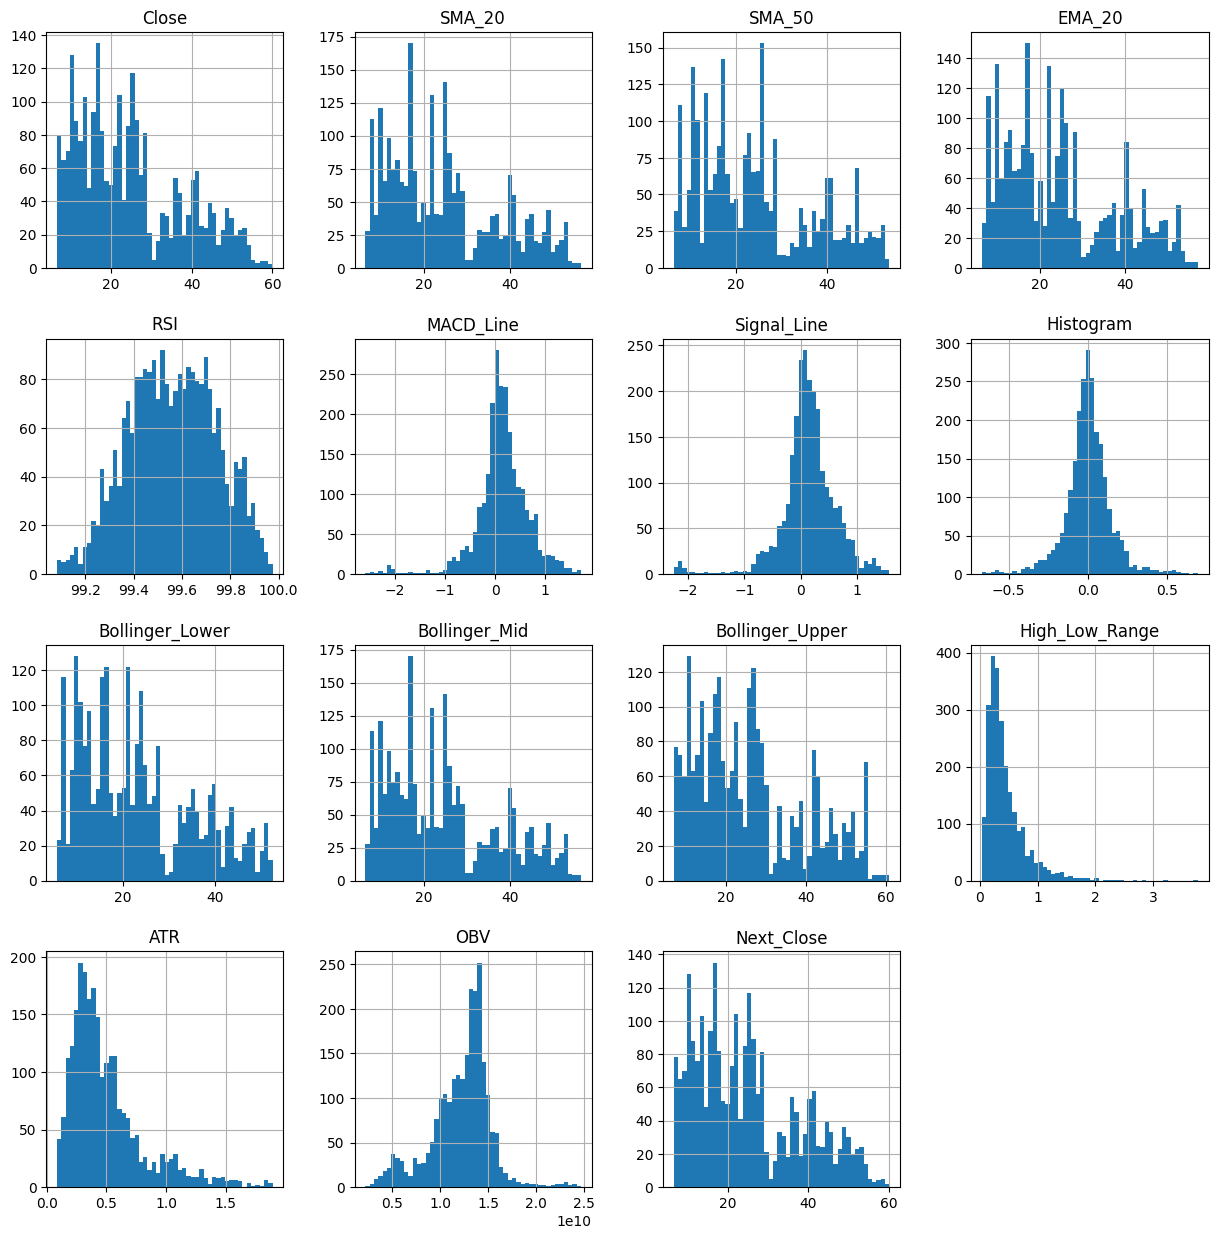

In [ ]:
# Plotting the Histograms for each feature for understanding the distribution
data[feature_columns].hist(figsize=(15,15),bins=50);

In [ ]:
# Plotting the Box-Plot for all the features
df_melted = data[feature_columns].melt(var_name='Feature', value_name='Value')
fig = px.box(df_melted, x='Feature', y='Value', points='outliers', color='Feature')
fig.update_layout(title='Boxplot of Features', xaxis_title='Feature', yaxis_title='Value')
fig.show()

In [ ]:
# Creating a function for checking the number of outliers in each column
def outlier_check(series):
  q1=np.percentile(series,25)
  q3=np.percentile(series,75)
  iqr=q3-q1
  lower_bound=q1-(1.5*iqr)
  upper_bound=q3+(1.5*iqr)
  count=0
  return ((series < lower_bound) | (series > upper_bound)).sum()

In [ ]:
# Calculting the Number of Outliers in each column
outlier_count={i:outlier_check(data[i]) for i in feature_columns}
outlier_count=pd.Series(outlier_count)
outlier_count.name="Number of Outliers"
outlier_count

,Number of Outliers
Close,0
SMA_20,0
SMA_50,0
EMA_20,0
RSI,0
MACD_Line,166
Signal_Line,160
Histogram,171
Bollinger_Lower,0
Bollinger_Mid,0


### Transformation of Features and Train-Validation-Test Split

In [ ]:
# Extracting the Feature Columns having Outliers and not having Outliers
features_with_outlier=outlier_count[outlier_count>0].index.to_list()
features_without_outlier=outlier_count[outlier_count==0].index.to_list()
print("Features with Outliers: ",features_with_outlier)
print()
print("Features without Outliers: ",features_without_outlier)

Features with Outliers:  ['MACD_Line', 'Signal_Line', 'Histogram', 'High_Low_Range', 'ATR', 'OBV']

Features without Outliers:  ['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'Bollinger_Lower', 'Bollinger_Mid', 'Bollinger_Upper', 'Next_Close']


In [ ]:
# Choosing split ratios
train_ratio, val_ratio = 0.7, 0.15
n = len(data)
n_train = int(n * train_ratio)
n_val   = int(n * (train_ratio + val_ratio))

train_data = data.iloc[:n_train]
val_data   = data.iloc[n_train:n_val]
test_data  = data.iloc[n_val:]

print("Number of Samples in the Training Set: ",train_data.shape[0])
print("Number of Samples in the Validation Set: ",val_data.shape[0])
print("Number of Samples in the Testing Set: ",test_data.shape[0])

Number of Samples in the Training Set:  1696
Number of Samples in the Validation Set:  364
Number of Samples in the Testing Set:  364


In [ ]:
# Different set of features
price_features   = ['Close','SMA_20','SMA_50','EMA_20',
                    'Bollinger_Lower','Bollinger_Mid','Bollinger_Upper']
bounded_features = ['RSI']
macd_features    = ['MACD_Line','Signal_Line','Histogram']
range_features   = ['High_Low_Range','ATR']
volume_features  = ['OBV']  # will log1p transformation then standardize

feature_cols = price_features + bounded_features + macd_features + range_features + volume_features

# Making Copies
X_train = train_data[feature_cols].copy()
X_val   = val_data[feature_cols].copy()
X_test  = test_data[feature_cols].copy()

# Doing log1p transformation for OBV first
def add_log_volume(dataframe):
    dataframe = dataframe.copy()
    dataframe['OBV'] = np.log1p(dataframe['OBV'].astype(float))
    return dataframe

X_train = add_log_volume(X_train)
X_val   = add_log_volume(X_val)
X_test  = add_log_volume(X_test)

# Defining the Scalers
price_scaler  = MinMaxScaler()
rsi_scaler    = MinMaxScaler()
macd_scaler   = StandardScaler()
range_scaler  = StandardScaler()
vol_scaler    = StandardScaler()     # on log1p(OBV)
target_scaler = StandardScaler()     # for target


# Using Column Transformer (Fitting on Train and Transform on Splits)
column_transformer=ColumnTransformer([('price_scaler',price_scaler,price_features),
                           ('rsi_scaler',rsi_scaler,bounded_features),
                           ('macd_scaler',macd_scaler,macd_features),
                           ('range_scaler',range_scaler,range_features),
                           ('vol_scaler',vol_scaler,volume_features)],remainder='passthrough')

X_train=column_transformer.fit_transform(X_train)
X_val=column_transformer.transform(X_val)
X_test=column_transformer.transform(X_test)


# Targets (Change in Close)
y_train = train_data['Target'].values.reshape(-1,1)
y_val   = val_data['Target'].values.reshape(-1,1)
y_test  = test_data['Target'].values.reshape(-1,1)

y_train_s = target_scaler.fit_transform(y_train)
y_val_s   = target_scaler.transform(y_val)
y_test_s  = target_scaler.transform(y_test)

# Keeping current close to reconstruct future price later (unscaled)
close_val_last = val_data['Close'].values
close_test_last= test_data['Close'].values
next_close_val = val_data['Next_Close'].values
next_close_test= test_data['Next_Close'].values

<b>Scaled the training, validation and testing set.</b>

### Creating Data for Long-Short Term Memory Model (LSTM)

In [ ]:
# Making LSTM Sequences
def make_sequences(X_df, y_array, lookback):
    Xv = X_df
    X_seq, y_seq = [], []
    for i in range(lookback, len(Xv)):
        X_seq.append(Xv[i-lookback:i, :])
        y_seq.append(y_array[i, 0])   # one-step ahead (already aligned)
    return np.array(X_seq), np.array(y_seq)

lookbacks = [30, 60, 90]  # whatever you want to try
results_seq = {}

for lb in lookbacks:
    Xtr_seq, ytr_seq = make_sequences(X_train, y_train_s, lb)
    Xva_seq, yva_seq = make_sequences(X_val,   y_val_s,   lb)
    Xte_seq, yte_seq = make_sequences(X_test,  y_test_s,  lb)
    results_seq[lb] = (Xtr_seq, ytr_seq, Xva_seq, yva_seq, Xte_seq, yte_seq)
    print(f"lookback={lb} -> X_train:{Xtr_seq.shape}, X_val:{Xva_seq.shape}, X_test:{Xte_seq.shape}")

lookback=30 -> X_train:(1666, 30, 14), X_val:(334, 30, 14), X_test:(334, 30, 14)
lookback=60 -> X_train:(1636, 60, 14), X_val:(304, 60, 14), X_test:(304, 60, 14)
lookback=90 -> X_train:(1606, 90, 14), X_val:(274, 90, 14), X_test:(274, 90, 14)


###### Don't Run

In [ ]:
# Function for generating the LSTM data
def generate_lstm_data(X,y,lookback):
  X_seq,y_seq=[],[]
  for i in range(lookback,len(X)):
    X_seq.append(X.iloc[i-lookback:i].values)
    y_seq.append(y.iloc[i])
  return np.array(X_seq),np.array(y_seq)

In [ ]:
# Preparing LSTM data
def prepare_lstm_data(X_train,y_train,X_val,y_val,X_test,y_test,lookback):
  X_train_seq,y_train_seq=generate_lstm_data(X_train,y_train,lookback)
  X_val_seq,y_val_seq=generate_lstm_data(X_val,y_val,lookback)
  X_test_seq,y_test_seq=generate_lstm_data(X_test,y_test,lookback)

  return X_train_seq,y_train_seq,X_val_seq,y_val_seq,X_test_seq,y_test_seq

In [ ]:
# Storing the data for different lookback values.
lookback_windows=[60,90]
results={}

In [ ]:
for lookback in lookback_windows:
  data=prepare_lstm_data(X_train_scaled,y_train_scaled,X_val_scaled,y_val_scaled,X_test_scaled,y_test_scaled,lookback)
  results[lookback]=data

### Building the LSTM Model

In [ ]:
pip install keras_tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Importing the tensorflow classes
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

In [ ]:
# Printing the different lookback windows
print("Lookback Windows are: ",lookbacks)

Lookback Windows are:  [30, 60, 90]


Defining the LSTM model function (For different lookback windows)

In [ ]:
final_results = {}
best_trained_model = {}

for lookback in lookbacks:
    print(f"\n Tuning GRU for Lookback={lookback}")

    # Getting the sequence for the particular lookback
    Xtr_seq, ytr_seq, Xva_seq, yva_seq, Xte_seq, yte_seq = results_seq[lookback]

    # ---- Model builder (predicts scaled ΔClose) ----
    def build_model(hp):
        model = Sequential()

        # First GRU Layer
        model.add(GRU(units=hp.Int('gru_units_1', 32, 128, step=16),
                      input_shape=(Xtr_seq.shape[1], Xtr_seq.shape[2]),
                      return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
        model.add(LayerNormalization())

        # Second GRU Layer
        model.add(GRU(units=hp.Int('gru_units_2', 32, 128, step=16),
                      return_sequences=False,recurrent_dropout=0.1, dropout=0.1))
        model.add(LayerNormalization())

        # Dense Layer
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.15))

        # Output Layer
        model.add(Dense(1, activation='linear')) # Output will scaled change in Close

        # Compiling the model
        model.compile(
            optimizer=Adam(hp.Float('lr', 1e-4, 1e-3, sampling='LOG')),
            loss=tf.keras.losses.Huber(delta=1.0),
            metrics=['mae']
        )                               # Huber Loss is robust to occasional high jumps
        return model


    # Defining the tuner
    tuner = kt.BayesianOptimization(
        build_model,
        objective=kt.Objective('val_mae', direction='min'),
        max_trials=10,
        directory='transform_delta_tuning',
        project_name=f'gru_lb_{lookback}',
        overwrite=True
    )


    # Defining Early Stopping Condition
    early_stop = EarlyStopping(monitor='val_mae', patience=5,
                               restore_best_weights=True, mode='min')

    tuner.search(
        Xtr_seq, ytr_seq,
        validation_data=(Xva_seq, yva_seq),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # Best Model and prediction on Change in Close (Scaled)
    best_model = tuner.get_best_models(1)[0]
    val_pred_s = best_model.predict(Xva_seq).reshape(-1, 1)
    tst_pred_s = best_model.predict(Xte_seq).reshape(-1, 1)

    # Inverse Scaling change in close to dollars
    val_pred_delta = target_scaler.inverse_transform(val_pred_s).reshape(-1)
    tst_pred_delta = target_scaler.inverse_transform(tst_pred_s).reshape(-1)

    val_true_delta = target_scaler.inverse_transform(yva_seq.reshape(-1, 1)).reshape(-1)
    tst_true_delta = target_scaler.inverse_transform(yte_seq.reshape(-1, 1)).reshape(-1)

    # Metrics on Change in Close (primary target)
    val_mae_delta = mean_absolute_error(val_true_delta, val_pred_delta)
    val_rmse_delta = np.sqrt(mean_squared_error(val_true_delta, val_pred_delta))

    tst_mae_delta = mean_absolute_error(tst_true_delta, tst_pred_delta)
    tst_rmse_delta = np.sqrt(mean_squared_error(tst_true_delta, tst_pred_delta))

    # Reconstructing next-day price = last_close + Change_in_Close_hat
    # Aligning last known Close per sequence:
    val_last_close = val_data['Close'].values[lookback:]
    tst_last_close = test_data['Close'].values[lookback:]

    val_price_hat = val_last_close[:len(val_pred_delta)] + val_pred_delta
    tst_price_hat = tst_last_close[:len(tst_pred_delta)] + tst_pred_delta

    # True next-day prices for comparison
    val_price_true = val_data['Next_Close'].values[lookback:]
    tst_price_true = test_data['Next_Close'].values[lookback:]

    # Metrics on reconstructed price (secondary, for intuition)
    val_mae_price = mean_absolute_error(val_price_true, val_price_hat)
    val_rmse_price = np.sqrt(mean_squared_error(val_price_true, val_price_hat))
    tst_mae_price = mean_absolute_error(tst_price_true, tst_price_hat)
    tst_rmse_price = np.sqrt(mean_squared_error(tst_price_true, tst_price_hat))

    # Storing in Dictionary
    final_results[lookback] = {
        'val_mae_delta':  val_mae_delta,  'val_rmse_delta':  val_rmse_delta,
        'tst_mae_delta':  tst_mae_delta,  'tst_rmse_delta':  tst_rmse_delta,
        'val_mae_price':  val_mae_price,  'val_rmse_price':  val_rmse_price,
        'tst_mae_price':  tst_mae_price,  'tst_rmse_price':  tst_rmse_price,
        'tst_price_hat':  tst_price_hat,  'tst_price_true':  tst_price_true,
        'val_price_hat':  val_price_hat,  'val_price_true':  val_price_true,
        'best_hparams':   tuner.get_best_hyperparameters(1)[0]
    }
    best_trained_model[lookback] = best_model

    print(f"Lookback {lookback} → Change in Close  | VAL MAE {val_mae_delta:.4f}, TEST MAE {tst_mae_delta:.4f}")
    print(f"Lookback {lookback} → Price   | VAL MAE {val_mae_price:.4f}, TEST MAE {tst_mae_price:.4f}")

Trial 10 Complete [00h 10m 30s]
val_mae: 1.2719371318817139

Best val_mae So Far: 1.258432388305664
Total elapsed time: 01h 07m 33s
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Lookback 90 → Change in Close  | VAL MAE 0.3752, TEST MAE 0.6462
Lookback 90 → Price   | VAL MAE 0.3752, TEST MAE 0.6462


In [ ]:
# Summary of the results
summary_rows = []
for lookback, results in final_results.items():
  row={
      'Lookback':lookback,
      'Val MAE Delta':results['val_mae_delta'],
      'Val RMSE Delta':results['val_rmse_delta'],
      'Test MAE Delta':results['tst_mae_delta'],
      'Test RMSE Delta':results['tst_rmse_delta'],
      'Val MAE Price':results['val_mae_price'],
      'Val RMSE Price':results['val_rmse_price'],
      'Test MAE Price':results['tst_mae_price'],
      'Test RMSE Price':results['tst_rmse_price']
      }
  summary_rows.append(row)

In [71]:
# Creating a dataframe of the summary
summary_df=pd.DataFrame(summary_rows)
summary_df.set_index("Lookback",inplace=True)
summary_df

,Val MAE Delta,Val RMSE Delta,Test MAE Delta,Test RMSE Delta,Val MAE Price,Val RMSE Price,Test MAE Price,Test RMSE Price
Lookback,,,,,,,,
30,0.340682,0.489193,0.618071,0.862380,0.340682,0.489193,0.618071,0.862380
60,0.354920,0.499252,0.650054,0.882017,0.354920,0.499252,0.650054,0.882017
90,0.375198,0.520239,0.646226,0.891509,0.375198,0.520239,0.646226,0.891509


In [75]:
# Best Hyperparameters
best_hyperparameters=[]
for lookback, results in final_results.items():
  row={
      'Lookback':lookback,
      'GRU Layer 1 Units':results['best_hparams'].values['gru_units_1'],
      'GRU Layer 2 Units':results['best_hparams'].values['gru_units_2'],
      'Learning Rate':results['best_hparams'].values['lr']
      }
  best_hyperparameters.append(row)
best_hyperparameters=pd.DataFrame(best_hyperparameters)
best_hyperparameters.set_index("Lookback",inplace=True)
print("The Best Hyperparameters Lookback wise are: ")
print()
best_hyperparameters

The Best Hyperparameters Lookback wise are: 



,GRU Layer 1 Units,GRU Layer 2 Units,Learning Rate
Lookback,,,
30,128,112,0.000108
60,112,96,0.000412
90,128,128,0.000211


In [73]:
# Best Lookback Model in terms of Lowest Test MAE Delta and Lowest Test MAE Price
best_lookback=summary_df[(summary_df["Test MAE Delta"]==(summary_df["Test MAE Delta"].min())) & (summary_df["Test MAE Price"]==(summary_df["Test MAE Price"].min()))].index[0]
print("Best Lookback model: ",best_lookback)
print("\n")
print("Best Lookback Model Summary: ")
print()
summary_df.loc[best_lookback]

Best Lookback model:  30


Best Lookback Model Summary: 



,30
Val MAE Delta,0.340682
Val RMSE Delta,0.489193
Test MAE Delta,0.618071
Test RMSE Delta,0.862380
Val MAE Price,0.340682
Val RMSE Price,0.489193
Test MAE Price,0.618071
Test RMSE Price,0.862380


In [68]:
# Saving the Best Model of Lookback 30
best_trained_model[best_lookback].save(f"best_model_{best_lookback}.h5")

best_trained_model[best_lookback].save(f"best_gru_lookback_{best_lookback}.keras", save_format="tf")